# Прогнозирование цен акций

## Загрузка библиотек

In [1]:
%pylab inline
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import normalize
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import requests
import apimoex
import yfinance as yf
import plotly
import time
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

Populating the interactive namespace from numpy and matplotlib


## Данные с Мосбиржи

### Загрузка минутных котировок акции с Мосбиржи

Моссбиржа предоставляет большое разнообразие данных по рынкам в свободном доступе. Однако в таком режиме, в отличие от платной подписки, есть возможность следить за рынком с 15 минутной задержкой. Но нам этого вполне достаточно.

In [2]:
def take_data(stock, start = None):
    with requests.Session() as session:
        data = apimoex.get_board_candles(session, stock, 1, start=start)
        df = pd.DataFrame(data)
        df.begin = pd.to_datetime(df.begin)
        df.set_index('begin', inplace=True)
    return df

In [3]:
df = take_data('SBER', start = '2021-05-07')
go.Figure(go.Ohlc(x=df.index, open=df.open, high=df.high, low=df.low, close=df.close))
# df.close.iplot()

### Загрузка данных по акциям с Мосбиржи

In [4]:
request_url = ('https://iss.moex.com/iss/engines/stock/markets/shares/securities.json')

with requests.Session() as session:
    iss = apimoex.ISSClient(session, request_url)
    data = iss.get()
    df = pd.DataFrame(data['securities'])
    df = df[df.BOARDID=='TQBR'].set_index('SECID')
df.head()

,BOARDID,SHORTNAME,PREVPRICE,LOTSIZE,FACEVALUE,STATUS,BOARDNAME,DECIMALS,SECNAME,REMARKS,...,ISSUESIZE,ISIN,LATNAME,REGNUMBER,PREVLEGALCLOSEPRICE,PREVADMITTEDQUOTE,CURRENCYID,SECTYPE,LISTLEVEL,SETTLEDATE
SECID,,,,,,,,,,,,,,,,,,,,,
ABRD,TQBR,АбрауДюрсо,201.500,10,1.00,A,Т+: Акции и ДР - безадрес.,1,Абрау-Дюрсо ПАО ао,None,...,98000184,RU000A0JS5T7,Abrau-Durso ao,1-02-12500-A,200.00,200.00,SUR,1,3,2021-05-11
ACKO,TQBR,АСКО ао,6.100,100,1.00,A,Т+: Акции и ДР - безадрес.,2,АСКО-СТРАХОВАНИЕ ПАО ао,None,...,536000000,RU000A0JXS91,ASKO-STRAKHOVANIE ao,1-01-52065-Z,6.10,6.10,SUR,1,3,2021-05-11
AFKS,TQBR,Система ао,34.177,100,0.09,A,Т+: Акции и ДР - безадрес.,3,"АФК ""Система"" ПАО ао",None,...,9650000000,RU000A0DQZE3,AFK Sistema,1-05-01669-A,34.01,34.01,SUR,1,1,2021-05-11
AFLT,TQBR,Аэрофлот,65.400,10,1.00,A,Т+: Акции и ДР - безадрес.,2,Аэрофлот-росс.авиалин(ПАО)ао,None,...,2444535448,RU0009062285,Aeroflot,1-01-00010-A,65.56,65.56,SUR,1,1,2021-05-11
AGRO,TQBR,AGRO-гдр,914.800,1,0.00,A,Т+: Акции и ДР - безадрес.,1,ГДР ROS AGRO PLC ORD SHS,None,...,0,US7496552057,GDR ROS AGRO PLC ORD SHS,None,914.80,914.80,SUR,D,1,2021-05-11


Будем использовать **df.index** как набор всех российских акций.

Однако фундаментальных данных по компаниям найти не удалось, поэтому будем искать альтернативы.

## Загрузка фундаментальных данных с FinancialModelingPrep

Здесь есть достаточно большой набор фундаментальных показателей как российских, так и иностранных акций, однако преимущественно они имеются начиная только с 2016 года.

In [5]:
# from fmp_python.fmp import FMP
# fmp = FMP(api_key='47a3212d4a233f392d6c193f8fdf26a3')
# fmp.get_quote('SBER.ME')

from urllib.request import urlopen
import json

def get_jsonparsed_data(tocken):
    url = ("https://financialmodelingprep.com/api/v3/ratios/{}?apikey=47a3212d4a233f392d6c193f8fdf26a3".format(tocken))
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return pd.DataFrame(json.loads(data))

df = get_jsonparsed_data('POLY.ME')

In [6]:
df.date = pd.to_datetime(df.date).dt.year
df = df.set_index('date')[df.columns[df.dtypes=='float64']]
df = df[df!=0]
df.dropna(axis='columns',how='any', inplace=True)

Расшифровка обозначений: https://financialmodelingprep.com/developer/docs/#Company-Financial-Ratios

In [7]:
df

,currentRatio,quickRatio,cashRatio,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
date,,,,,,,,,,,,,,,,,,,,,
2020,2.175633,0.613924,0.610759,214.021258,214.021258,29.096546,184.924712,0.605934,0.509599,0.490401,...,269.539154,711.077050,1268.029026,647.843689,647.843689,5.618109,269.539154,0.000623,527.321525,385.729109
2019,2.756381,0.587007,0.587007,196.374269,196.374269,22.259816,174.114453,0.465863,0.354752,0.275770,...,220.305404,1028.550853,1898.863113,709.345416,709.345416,35.450981,220.305404,0.000486,616.400261,256.070752
2018,2.893112,0.900238,0.900238,201.858908,201.858908,27.064882,174.794027,0.430832,0.307151,0.244431,...,194.951273,936.864428,1967.969657,648.317489,648.317489,-261.444654,194.951273,0.000640,633.756873,241.179748
2017,3.556075,0.168224,0.168224,169.629295,169.629295,20.461121,149.168174,0.390634,0.279890,0.244077,...,156.699283,803.415813,1896.061318,533.600746,533.600746,-69.641246,156.699283,0.000485,558.209371,217.604589
2016,2.512195,0.167247,0.167247,212.700946,212.700946,22.003546,190.697400,0.465572,0.367656,0.356286,...,181.571813,727.666279,1109.761314,542.317321,542.317321,9.400798,181.571813,0.000550,493.436206,292.995087


## Загрузка фундаментальных данных со Smart-lab

На данном сайте есть большое количество фундаментальных данных по российским акциям, благо даже есть ссылка на скачивание csv таблиц для каждой из них: https://smart-lab.ru/q/POLY/f/y/MSFO/.

In [8]:
def smartlab(ticker, frequency='y'):
    if frequency == 'y':
        df = pd.read_csv("https://smart-lab.ru/q/{}/f/y/MSFO/download/".format(str(ticker)), sep=';', index_col='Unnamed: 0')
    elif frequency == 'q':
        df = pd.read_csv("https://smart-lab.ru/q/{}/f/q/MSFO/download/".format(str(ticker)), sep=';', index_col='Unnamed: 0')
    return df.T.dropna(axis='columns', how='all')

In [9]:
smartlab('SBER', 'y').tail()

,Дата отчета,"Чистый операц доход, млрд руб","Чист. проц. доходы, млрд руб","Чист. комисс. доход, млрд руб","Доходы по цб, млрд руб","Чистая прибыль, млрд руб","Див.выплата, млрд руб","Дивиденд, руб/акцию","Див доход, ао, %","Дивиденд ап, руб/акцию",...,"EPS, руб","ROE, %","ROA, %","Чистая процентная маржа, %","Рентабельность банка, %","P/E,","P/B,","Персонал, чел","Производительность труда, млн руб/чел/год","Расходы/чел/год, тыс.р"
2017,17.04.2018,1903,1349,"394,2",NaN,"748,7","271,0",12,"5,3%",12,...,"34,7","24,2%","2,9%","6,00%","39,3%","6,74","1,47",310300,"6,13",1298
2018,28.02.2019,1936,1397,"445,3",NaN,"831,7","361,0",16,"8,6%",16,...,"38,5","23,1%","3,2%","5,70%","43,0%","5,04","1,09",293800,"6,59",1376
2019,27.02.2020,2013,1416,"497,9",NaN,"845,0","422,4","18,7","7,3%","18,7",...,"39,1","22,2%","3,1%","5,16%","42,0%","6,78","1,28",281300,"7,16",1599
2020,04.03.2021,2193,1608,"553,0",NaN,"761,0","422,4","18,7","5,9%","18,7",...,"35,3","16,1%","2,3%","5,47%","34,7%","9,41","1,43",285600,"7,68",1632
LTM,NaN,2273,1658,"560,9",NaN,"945,3","422,0","18,7","5,9%","18,7",...,"43,8","24,3%","3,3%","5,40%","41,6%","7,58","1,36",278200,"8,17",1725


In [10]:
smartlab('SBER', 'q').tail()

,Дата отчета,"Чистый операц доход, млрд руб","Чист. проц. доходы, млрд руб","Чист. комисс. доход, млрд руб","Доходы по цб, млрд руб","Чистая прибыль, млрд руб","Див.выплата, млрд руб","Дивиденд, руб/акцию","Див доход, ао, %","Дивиденд ап, руб/акцию",...,"EV, млрд руб","EPS, руб","ROE, %","ROA, %","Чистая процентная маржа, %","Рентабельность банка, %","P/E,","P/B,","Персонал, чел","Расходы/чел/год, тыс.р"
2020Q2,30.07.2020,"514,9","398,5","120,0",NaN,"166,7",NaN,NaN,NaN,NaN,...,4586,"7,72","14,2%","2,1%","5,61%","32,4%","7,00","0,94",276600,"397,7"
2020Q3,29.10.2020,"592,6","411,3","147,7",NaN,"271,4",NaN,NaN,NaN,NaN,...,5153,"12,6","22,8%","3,2%","5,48%","45,8%","6,69","1,07",278200,"371,0"
2020Q4,04.03.2021,"576,9","426,3","158,9",NaN,"202,4","422,0","18,7","6,9%","18,7",...,6091,"9,38","16,6%","2,2%","5,34%","35,1%","8,00","1,22",285600,"510,5"
2021Q1,29.04.2021,"589,0","421,5","134,3",NaN,"304,8",NaN,NaN,NaN,NaN,...,7161,"14,1","24,3%","3,3%","5,18%","51,7%","7,58","1,36",278200,"434,9"
LTM,NaN,2273,1658,"560,9",NaN,"945,3","422,0","18,7","5,9%","18,7",...,7161,"43,8","24,3%","3,3%","5,40%","41,6%","7,58","1,36",278200,1725


Такого типа данные заполняются вручную из отчетов компаний, поэтому на удобство использования и полноту данных расчитывать не приходится.
**LTM** - данные за последние четыре квартала. Могут пригодиться, но из обучения убираем.

Итак, функция, собирающая полную таблицу по списку тикеров:

In [11]:
def table_smartlab(tickers, *args):
    LTM = []
    broken_list = []
    data_stocks = []
    for ticker in tickers:
        try:
            dat = smartlab(ticker, *args)
            dat['SECID'] = ticker
            LTM.append(dat.loc['LTM'])
            data_stocks.append(dat.drop('LTM'))
        except Exception:
            broken_list.append(ticker)
            continue
        
    LTM = pd.concat(LTM, 1).T.set_index('SECID').dropna(axis='columns', how='all')
    LTM = LTM.replace('%', ' ', regex=True).replace(',', '.', regex=True)
    LTM.columns = LTM.columns.str.strip()
    
    table = pd.concat(data_stocks, axis=0)
    table.index.names = ['year']
    table.reset_index(inplace=True)
    table = table.groupby(['SECID', 'year']).first()
    table = table.replace('%', ' ', regex=True).replace(',', '.', regex=True)
    table.columns = table.columns.str.strip()
    return table, LTM

In [12]:
# table, LTM = table_smartlab(df.index, 'q')

table = pd.read_csv('fundamental.csv', index_col=['SECID', 'year'])
LTM = pd.read_csv('LTM.csv', index_col='SECID')

In [13]:
table[10:15]

Дата отчета  Выручка, млрд руб  EBITDA, млрд руб  \
SECID year                                                    
AFKS  2018  03.04.2019              777.4             265.3   
      2019  07.04.2020              656.9             223.9   
      2020  08.04.2021              691.6             236.3   
AFLT  2008         NaN                NaN               NaN   
      2009         NaN                NaN               NaN   

            Чистая прибыль н/с, млрд руб  Чистая прибыль, млрд руб  \
SECID year                                                           
AFKS  2018                         -45.9                      1.11   
      2019                          28.6                     53.40   
      2020                          10.2                     16.00   
AFLT  2008                           NaN                       NaN   
      2009                           NaN                       NaN   

            Див.выплата, млрд руб  Дивиденд, руб/акцию  Див доход, ао, %  \
SECID year                                                                 
AFKS  2018                  1.060                 0.11               1.4   
      2019                  1.250                 0.13               0.9   
      2020                    NaN                  NaN               NaN   
AFLT  2008                  0.200                 0.18               0.7   
      2009                  0.388                 0.35               0.7   

            Дивиденды/прибыль, %  Себестоимость, млрд руб  ...  \
SECID year                                                 ...   
AFKS  2018                  95.0                    366.0  ...   
      2019                   2.0                    301.9  ...   
      2020                   NaN                    330.0  ...   
AFLT  2008                   NaN                      NaN  ...   
      2009                   NaN                      NaN  ...   

            Внутренняя цена на уголь, $/т  Экспортная цена на уголь, $/т  \
SECID year                                                                 
AFKS  2018                            NaN                            NaN   
      2019                            NaN                            NaN   
      2020                            NaN                            NaN   
AFLT  2008                            NaN                            NaN   
      2009                            NaN                            NaN   

            Средняя цена на уголь, $/т  Производство алюминия, тыс т  \
SECID year                                                             
AFKS  2018                         NaN                           NaN   
      2019                         NaN                           NaN   
      2020                         NaN                           NaN   
AFLT  2008                         NaN                           NaN   
      2009                         NaN                           NaN   

            Продажи алюминия, тыс т  Продажи ПДС, тыс т  Цена алюминия, $/т  \
SECID year                                                                    
AFKS  2018                      NaN                 NaN                 NaN   
      2019                      NaN                 NaN                 NaN   
      2020                      NaN                 NaN                 NaN   
AFLT  2008                      NaN                 NaN                 NaN   
      2009                      NaN                 NaN                 NaN   

            Себестоимость алюминия, $/т  Загрузка мощностей, %  \
SECID year                                                       
AFKS  2018                          NaN                    NaN   
      2019                          NaN                    NaN   
      2020                          NaN                    NaN   
AFLT  2008                          NaN                    NaN   
      2009                          NaN                    NaN   

            Неработающие кр

## Загрузка котировок с Мосбиржи или Yahoo Finance

Напишем наперед три потенциально полезные функции:
   * Ежедневные цены закрытия акции (скачиваются напрямую с Мосбиржи или Yahoo Finance)
   * Среднемесячные цены акции (высчитываются по значениям предыдущего пункта)
   * Среднегодовые цены акции (высчитываются по значениям предыдущего пункта)

In [14]:
def Daily_close(ticker, from_='MOEX', ru=True, start = None):
    if from_ == 'MOEX':
        with requests.Session() as session:
            data = apimoex.get_board_candles(session, ticker, start=start)
            df = pd.DataFrame(data)
            df.begin = pd.to_datetime(df.begin)
            df.set_index('begin', inplace=True)
            df.index.names = ['Date']
    elif from_ == 'yahoo':
        if ru:
            ticker = ticker + '.ME' 
        df = yf.download(ticker)
        df.columns = df.columns.str.lower()
    return df

In [15]:
def AverageMonth(ticker, *args, **kwargs):
    df = Daily_close(ticker, *args, **kwargs)
    val, ye, mo = [], [], []
    for y in sorted(set(df.index.year)):
        for m in set(df.index[df.index.year == y].month):
            month = df.loc[(df.index.year == y)&(df.index.month == m), 'close']
            val.append(np.round(month.sum()/len(month), 2))
            ye.append(y)
            mo.append(m)
    d = pd.DataFrame(np.array([ye, mo, val]).T, columns=['year', 'month', 'close'])
    d.year = d.year.astype(int)
    d.month = d.month.astype(int)
    d['ticker'] = ticker
    d['day'] = np.ones(len(d))
    d['date'] = pd.to_datetime(d[['year', 'month', 'day']])
    d.set_index('date', inplace=True)
    d = d[['close', 'ticker']]
    return d

In [16]:
def AverageYear(ticker, *args, **kwargs):
    df = AverageMonth(ticker, *args, **kwargs)
    val, ye = [], []
    for y in sorted(set(df.index.year)):
        year = df.loc[df.index.year == y, 'close']
        val.append(np.round(year.sum()/len(year), 2))
        ye.append(y)
    d = pd.DataFrame(np.array([ye, val]).T, columns = ['year', 'close'])
    d.year = d.year.astype(int)
    d['ticker'] = df.ticker[0]
    d.set_index('year', inplace=True)
    return d

In [17]:
K = AverageYear('POLY', start = '2020-01-01')
K

,close,ticker
year,,
2020,1488.83,POLY
2021,1621.85,POLY


## Первичный отбор признаков

Аналитически подберем несколько важных признаков и будем считать их основными:

In [18]:
main_features = ['ROE, %', 'Чистая рентаб, %', 'Рентаб EBITDA, %', 'Долг/EBITDA,', 'P/E,', 'P/S,', 'P/BV,', 'EV/EBITDA,']

Text(0.5, 0.98, 'Heatmap of the main features')

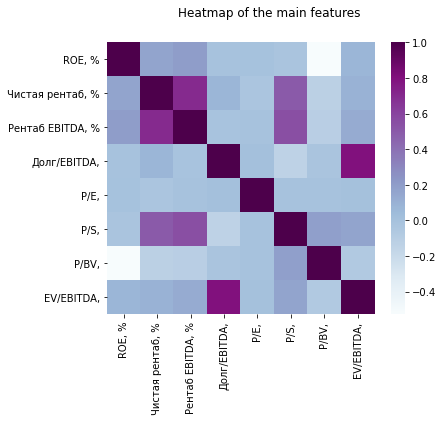

In [19]:
fig = plt.figure(figsize=(6,5))
sns.heatmap(table[main_features].corr(), cmap='BuPu')
plt.suptitle('Heatmap of the main features')

Также напишем функцию для сортировки признаков, работать которая будет в три этапа: 
   * Избавляемся от признаков, в которых доля *NA* превышает **max_portion_NA**. 
   * В коррелляционной матрице вычеркиваем значения, корелляция которых больше **max_corr_value**.
   * Для каждого признака считаем количество вычеркнутых значений и выбрасываем те, у кого это количество превышает **max_num_bad_feats**.

In [20]:
def best_feats(table, max_portion_NA, max_corr_value, max_num_bad_feats):
    top_na = table.isna().sum().sort_values()/len(table)
    corr = table[top_na[top_na < max_portion_NA].index].corr()
    k = corr[(corr < max_corr_value)|(corr==1)].isna().sum().sort_values()
    return k[k < max_num_bad_feats + 1].index

best_features = best_feats(table, max_portion_NA = 0.5, max_corr_value = 0.8, max_num_bad_feats = 2)

Text(0.5, 0.98, 'Heatmap of the best features')

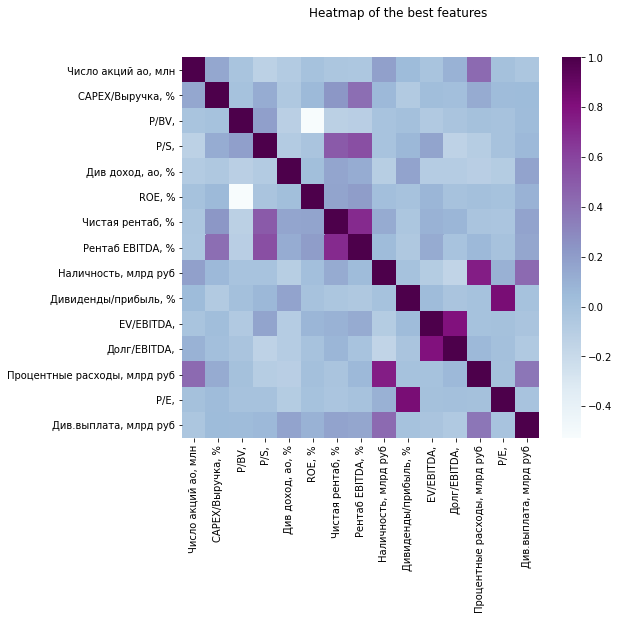

In [21]:
fig = plt.figure(figsize=(8,7))
sns.heatmap(table[best_features].corr(), cmap='BuPu')
plt.suptitle('Heatmap of the best features')

## Среднегодовое фундаментальное обучение на российских акциях

In [22]:
table[main_features].dropna()

ROE, %  Чистая рентаб, %  Рентаб EBITDA, %  Долг/EBITDA,    P/E,  \
SECID year                                                                     
AFKS  2013    11.1               8.8              21.8          0.07    8.36   
      2014    -8.2              -3.0              25.6          2.62   -5.75   
      2015    -2.4              -0.9              26.0          2.20  -29.10   
      2016     0.7               0.2              26.9          2.03  151.00   
      2017     8.6               0.6              28.3          2.65   28.30   
...            ...               ...               ...           ...     ...   
YNDX  2016    18.3              18.6              34.4         -1.70   29.20   
      2017    18.5              16.3              30.9         -1.65   40.70   
      2018    12.1              17.3              31.0         -1.74   28.80   
      2019    12.1              13.4              29.1         -1.73   37.80   
      2020     6.4               9.6              22.8         -3.11   76.30   

            P/S,  P/BV,  EV/EBITDA,  
SECID year                           
AFKS  2013  0.73   1.23        3.44  
      2014  0.17   1.23        3.29  
      2015  0.25   1.98        3.17  
      2016  0.32   3.92        3.22  
      2017  0.17  -1.12        3.23  
...          ...    ...         ...  
YNDX  2016  5.42   6.52       14.10  
      2017  6.65   9.13       19.80  
      2018  4.99   5.40       14.40  
      2019  5.08   6.73       15.70  
      2020  7.34   8.11       29.10  

[590 rows x 8 columns]

Итак, имеем матрицу признаков, состоящую из фундаментальных показателей, теперь необходимо подготовить целевой параметр, который мы будем предсказывать.

### Подготовка целевой функции

Данные по признакам у нас имеются с годовой частотой, значит более частые предсказания делать смысла нет. Также считаем, что фундаментальные показатели посчитанные за текущий год влияют только на следующий, тогда предсказывать будем **изменение цены акции с текущего года на следующий**. Задача временного ряда свелась к влиянию набора показателей за один год на единственное значение **изменения цены** за следующий. 

Данные по котировкам, на удивление, попадаются неполные, хотя казалось, узкое горлышко уже пройдено. К тому же, не везде совпадают с разных источников.

In [23]:
pd.concat([table[main_features].loc['AFKS'].dropna(),
           AverageYear('AFKS', 'yahoo').close.rename('yahoo_close'),
               AverageYear('AFKS', 'MOEX').close.rename('MOEX_close')], 1)

[*********************100%***********************]  1 of 1 completed


,"ROE, %","Чистая рентаб, %","Рентаб EBITDA, %","Долг/EBITDA,","P/E,","P/S,","P/BV,","EV/EBITDA,",yahoo_close,MOEX_close
year,,,,,,,,,,
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.23,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.23,NaN
2013,11.1,8.8,21.8,0.07,8.36,0.73,1.23,3.44,30.44,NaN
2014,-8.2,-3.0,25.6,2.62,-5.75,0.17,1.23,3.29,32.79,27.93
2015,-2.4,-0.9,26.0,2.20,-29.10,0.25,1.98,3.17,17.56,17.57
2016,0.7,0.2,26.9,2.03,151.00,0.32,3.92,3.22,20.13,20.13
2017,8.6,0.6,28.3,2.65,28.30,0.17,-1.12,3.23,15.92,15.92
2018,6.5,0.1,34.1,2.21,69.30,0.10,-0.50,2.50,9.83,9.84
2019,129.0,8.1,34.1,2.60,2.75,0.22,-1.40,3.26,11.25,11.25


Поэтому напишем функцию с выбором источника:

In [24]:
def X_with_y(X, kind='MOEX'):
    X = X.dropna()
    X_new = []
    for ticker in sorted(set(X.reset_index().SECID)):
        try:    
            if kind=='MOEX':
                K = AverageYear(ticker, 'MOEX').join(X.loc[ticker])
                
            if kind=='yahoo':
                K = AverageYear(ticker, 'yahoo').join(X.loc[ticker])
                
            if kind=='both':
                data = []
                data.append(AverageYear(ticker, 'MOEX'))
                data.append(AverageYear(ticker, 'yahoo'))
                K = data[np.argmin([data[0].index.min(), data[1].index.min()])].join(X.loc[ticker])
                
            K = K[K.close!=0]
            K['price_change'] = (K.close - K.close.shift(1)).shift(-1)
#             K['price_change_mean'] = K['price_change'].mean()
#             K['price_change_std'] = K['price_change'].std(ddof=1)
#             K['price_change_stand'] = (K['price_change']-K['price_change_mean'])/K['price_change_std']
#             K['price_change_min'] = K['price_change'].min()
#             K['price_change_max'] = K['price_change'].max()
#             K['price_change_scale'] = (K['price_change']-K['price_change_min'])/(K['price_change_max']-K['price_change_min'])
            K['median'] = K['close'].median()
            K['mean'] = K['close'].mean()
            K['price_change_mean'] = K['price_change']/K.close.mean()
            K['price_change_median'] = K['price_change']/K.close.median()
            X_new.append(K)
        except Exception:
            continue
            
    X_new = pd.concat(X_new).reset_index().set_index(['ticker', 'year'])
    return X_new

Чтобы корректно обучаться по целевому признаку, его нужно некоторым образом нормировать. Деление на медиану цен для каждой акции неплохо справляется с этой задачей. Теперь величина иземенения цен соотвествует своему размеру для акций разных ценовых категорий.

In [25]:
# X_y = X_with_y(table[main_features])

In [26]:
# X_y.to_csv('X_y')

### Последняя подготовка данных и борьба с выбросами

In [27]:
X_y = pd.read_csv('X_y', index_col=['ticker', 'year'])

<AxesSubplot:xlabel='price_change_median', ylabel='Count'>

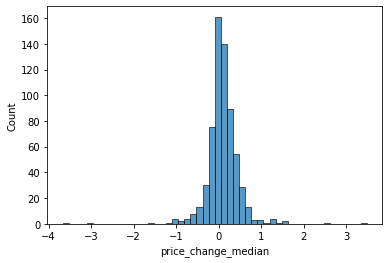

In [28]:
sns.histplot(X_y['price_change_median'], bins=50)

In [63]:
X_y = X_y.dropna()
X_test = X_y.reset_index()[X_y.reset_index().year==2020].set_index(['ticker', 'year'])
X_train = X_y.reset_index()[X_y.reset_index().year!=2020].set_index(['ticker', 'year'])

In [64]:
X_train.drop(('DIOD', 2017), inplace=True)
X_train.drop(('KMAZ', 2015), inplace=True)
X_train.drop(('NMTP', 2016), inplace=True)
X_train.drop(('MTSS', 2017), inplace=True)
X_train.drop(('MSTT', 2019), inplace=True)

### Метрики качества 

Осталось придумать как мы будем сравнивать качество модели. 

В первую очередь нас интересует сколько ростов и падений акций модель угадала, назовем **accuracy**:

In [65]:
def accuracy(a, b):
    right = np.sign(X_test['price_change'])==np.sign(X_test['price_change_pred'])
    return right.sum()/len(right)

Также интересует насколько сильно модель ошиблась, для этого посчитаем абсолютную ошибку. Но опять же, так как цены акций могут быть в разных ценовых категориях, необходимо привести некоторую нормировку, причем симметрично относительно предсказанной и настоящей величинами.
   1. Считаем разность
   2. В зависимости от знаков исходных величин и разности проводим нормировку, переводя разность в симметричный интервал около 0
   3. Модулем отражаем в положительную ось, переводя интервал, строго говоря, к $[0, \infty )$. 
   
Теперь при уменьшении метрики, увеличивается качество.

In [66]:
def AE(a, b):
    k = a - b
    data = k.copy()
    data.loc[(a > 0)&(k>0)] /= a[((a > 0)&(k>0))]
    data.loc[(a > 0)&(k<0)] /= b[((a > 0)&(k<0))]
    data.loc[(a < 0)&(k<0)] /= a[((a < 0)&(k<0))]
    data.loc[(a < 0)&(k>0)] /= b[((a < 0)&(k>0))]
    return data.abs()

### Непосредственно обучение

#### Линейная регрессия

In [67]:
m2 = sm.OLS(X_train['price_change_median'], X_train[main_features])
fitted = m2.fit(cov_type='HC1')
print(fitted.summary())

                                 OLS Regression Results                                 
Dep. Variable:     price_change_median   R-squared (uncentered):                   0.122
Model:                             OLS   Adj. R-squared (uncentered):              0.106
Method:                  Least Squares   F-statistic:                              8.176
Date:                 Sat, 08 May 2021   Prob (F-statistic):                    2.65e-10
Time:                         18:08:38   Log-Likelihood:                         -69.852
No. Observations:                  432   AIC:                                      155.7
Df Residuals:                      424   BIC:                                      188.3
Df Model:                            8                                                  
Covariance Type:                   HC1                                                  
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

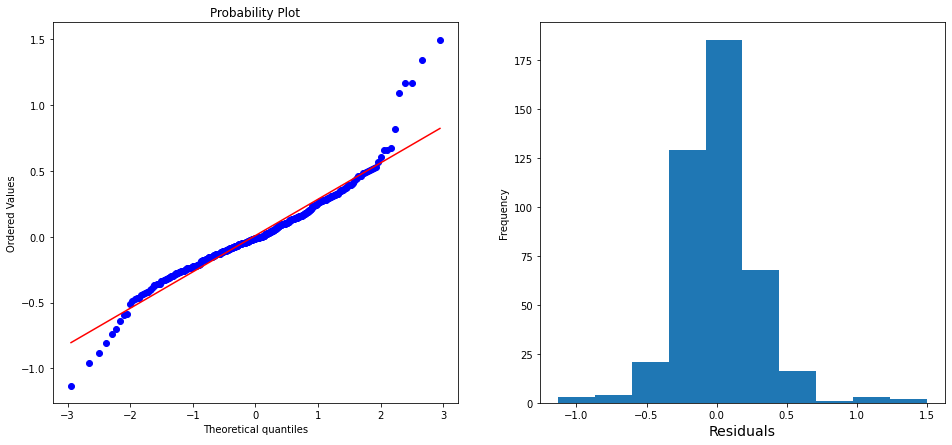

In [68]:
plt.figure(figsize(16,7))
plt.subplot(121)
stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

<Figure size 576x504 with 0 Axes>

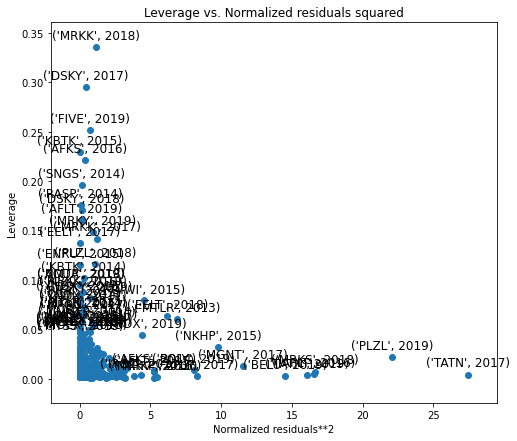

In [69]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='price_change_median'>

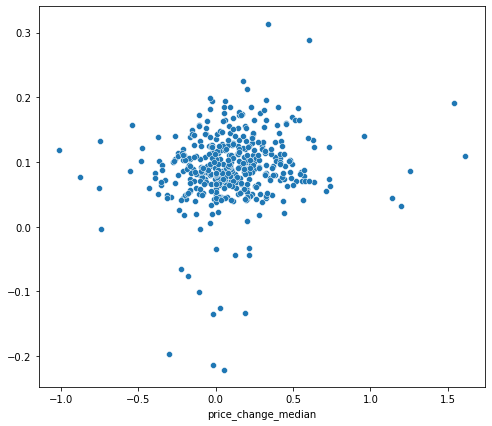

In [70]:
sns.scatterplot(X_train['price_change_median'], fitted.fittedvalues)

In [71]:
X_test['price_change_pred'] = fitted.predict(X_test[main_features])*X_test['median']

In [72]:
X_test[['price_change','price_change_pred']].iplot()

In [73]:
X_test['metric'] = AE(X_test['price_change'], X_test['price_change_pred'])
print('metric: ', X_test['metric'].sum())

X_test.sort_values('metric')[:10][['close','price_change', 'price_change_pred', 'metric']]

metric:  258.54759824684373


,,close,price_change,price_change_pred,metric
ticker,year,,,,
TGKA,2020,0.01,0.00,0.000871,0.000871
MRKY,2020,0.05,0.00,0.000893,0.000893
MRKZ,2020,0.05,0.00,0.002024,0.002024
MRKV,2020,0.07,0.00,0.009811,0.009811
RSTI,2020,1.50,0.09,0.079981,0.111324
POLY,2020,1488.83,132.95,114.409716,0.139453
MDMG,2020,463.81,76.51,60.468296,0.209668
SIBN,2020,339.41,13.67,17.529400,0.220167
HYDR,2020,0.71,0.11,0.083748,0.238656


In [80]:
def sort_forecast_for_today(X_test, today='2021-05-07'):
    df = X_test.copy()
    df['prediction_2021'] = df['close'] + df['price_change_pred']
    df.reset_index(inplace=True)
    for ticker in df.ticker:
        df.loc[df.ticker==ticker, today] = Daily_close(ticker, start=today).close.loc[today]

    df['metric_for_today'] = AE(df['prediction_2021'], df[today])
    new_column = 'price_'+str(df.year[0])
    df.rename(columns={'close': new_column}, inplace=True)
    df = df.drop('year', 1).set_index('ticker')
    return df.sort_values('metric_for_today')[[new_column, 'prediction_2021', today, 'metric_for_today']]

In [81]:
sort_forecast_for_today(X_test, today='2021-05-07')

,price_2020,prediction_2021,2021-05-07,metric_for_today
ticker,,,,
MSRS,1.16,1.233603,1.2300,0.002921
AKRN,5719.32,5923.291055,5964.0000,0.006826
LSRG,774.45,842.225923,828.6000,0.016178
MRKK,27.14,25.653556,25.2200,0.016900
MSNG,2.09,2.240783,2.2855,0.019566
...,...,...,...,...
PIKK,471.83,502.365048,989.3000,0.492202
RNFT,430.59,343.511076,171.0000,0.502199
BELU,1252.84,1290.671733,3620.0000,0.643461


### Сортировка российских акций по фундаментальным показателям